# <center><a href='https://mybinder.org/v2/gh/fortierq/notebooks/master?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Ffortierq%252Fnotebooks%26urlpath%3Dlab%252Ftree%252Fnotebooks%252Fnb%252Fimage_processing%252Fhist_equal%252Fhist_equal.ipynb%26branch%3Dmaster'>Égalisation d'histogramme            <img src=https://mybinder.org/badge.svg></a></center>
## Introduction

L'égalisation d'histogramme est une méthode pour améliorer le contraste d'une image. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

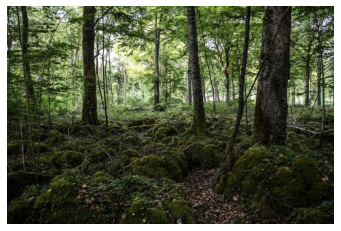

In [6]:
foret = plt.imread("foret.jpg")
plt.axis('off')
plt.imshow(foret);

Cette image est bien sombre... Voici ce que nous allons obtenir avec la méthode d'égalisation d'histogramme:  
![img](foret_eg.png)

## Niveau de gris

Pour simplifier, nous allons d'abord travailler sur une image en noir et blanc. Pour cela, on utilise une formule classique consistant à convertir un pixel de couleur ($R$, $G$, $B$) en une intensité de gris égal à:
$$0.2126\times R + 0.7152\times G + 0.0722\times B$$

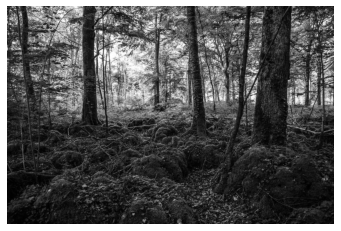

In [5]:
def gray(im):
    lum = np.zeros((1, 1, 3))
    lum[0, 0, :] = [0.2126, 0.7152, 0.0722]
    return np.uint8(np.round(np.sum(lum*im, axis = 2)))
foretg = gray(foret)
plt.axis('off')
plt.imshow(foretg, cmap='gray');

Dans le code ci-dessus, `lum*im` permet de coefficienter chaque niveau de rouge (resp. vert, bleu) par 0.2126 (resp. 0.7152, 0.0722) grâce aux propriétés des tableaux numpy (broadcasting et multiplication terme à terme).

## Histogrammes

Dans une image en noir et blanc, chaque pixel possède une intensité, généralement codée sur 8 bits et possédant donc $2^8 = 256$ valeurs possibles, allant de 0 (complètement noir) à 255 (complètement blanc). 

L'**histogramme** de cette image est alors un tableau `h` de taille 256 tel que `h[i]` soit le nombre de pixels d'intensité `i`.
L'histogramme d'une image informe donc sur la répartition des intensités parmi les pixels de l'image. 

In [7]:
def hist(im):
    h = np.zeros((256))
    for p in im.ravel():
        h[p] += 1
    return h

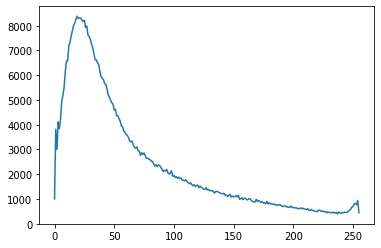

In [9]:
h_foret = hist(foretg)
plt.plot(h_foret);

Comme on avait pu le voir directement sur l'image, la plupart des pixels sont sombres (intensité proche de 0), avec un petit pic lumineux (les rayons de soleils que l'on peut apercevoir).

## Méthode de la transformée inverse

Afin d'améliorer le contraste, nous souhaiterions modifier l'intensité $x$ de chaque pixel par une intensité $T(x)$ de façon à ce que l'histogramme soit mieux réparti, en se rapprochant de la distribution uniforme.

Ce problème est similaire à celui de la simulation de variables aléatoires. En effet, s'il est relativement simple (?) de simuler une loi uniforme $U$ à l'aide d'un ordinateur, il est légèrement plus délicat de simuler une autre loi $X$. La méthode de la **transformée inverse** consiste à appliquer une transformation $T$ sur $U$ de façon à obtenir $X$. 
Plus précisément, soit $F$ la **fonction de répartition** de $X$, définie par:
$$F(x) = \mathbb{P}(X \leq x)$$
Des théorèmes en théorie des probabilités assurent que $F$ est croissante et que $X$ est déterminée par $F$.

La transformation $T$ utilisée est alors la fonction inverse $F^{-1}$ de $F$. <br>
(Remarque: $F$ n'est pas forcément inversible et il faut alors définir un "pseudo-inverse". Pour simplifier, nous supposerons $F$ inversible.)

En effet, déterminons la fonction de répartition de $T(U) = F^{-1}(U)$:
$$\mathbb{P}(F^{-1}(U) \leq x) = \mathbb{P}(U \leq F(x)) = F(x)$$
Ainsi, $F^{-1}(U)$ a pour fonction de répartition $F$ et, une loi de probabilité étant déterminée par sa fonction de répartition, $F^{-1}(U)$ a donc pour loi $X$.

**Résumé: pour simuler $X$ à partir d'une loi uniforme $U$, il suffit de calculer $F^{-1}(U)$**.

Exemple: simulons une loi exponentielle $X$ (définie par $\mathbb P (X \leq x) = \lambda e^{- \lambda x}$ si $x \geq 0$, $\mathbb P (X \leq x) = 0$ sinon). <br>
La fonction de répartition de $X$ est:
$$F(x) = \int_0^x \lambda e^{- \lambda t} dt = [-e^{- \lambda t}]_0^x = 1 - e^{- \lambda x} $$
L'inverse de $F$ est donc:
$$F^{-1}(x) = -\frac{\ln(1 - x)}{\lambda}$$

In [10]:
def Finv(x, l):
    return -np.log(1 - x)/l
def simuler_exp(l):
    r = np.random.random()
    return Finv(r, l)

In [11]:
simuler_exp(2)

0.5876888409833344

Remarque: il existe de nombreuses autres méthodes de simulations de variables aléatoires, comme l'importance sampling ou la méthode de Monte-Carlo.

## Égalisation d'histogramme

Comment transposer la méthode précédente à notre problème sur une image? <br>
Premièrement, les intensités des pixels sont des valeurs entre 0 et 255, contrairement aux probabilités entre 0 et 1. Pour passer à des valeurs entre 0 et 1, nous allons tout simplement diviser les intensités par 255. <br>
Deuxièmement, passer d'un histogramme quelconque à un histogramme "uniforme" est la démarche inverse de la méthode précédente (qui partait d'une distribution uniforme). Plutôt que d'appliquer $F^{-1}$, nous allons donc appliquer $F$. <br>
Enfin, l'histogramme que nous manipulons est discret (il n'y a qu'un nombre fini de valeurs). Dans ce cas, l'intégrale est remplacée par une somme. <br>
Ainsi, la transformation que nous allons utiliser est la suivante, où $i$ est une intensité et $n$ le nombre de pixels:
$$F(i) = \frac{1}{n}\sum_{k = 0}^{i-1} h(i)$$
Voici un exemple pour mieux comprendre cette formule: si notre image possède 10 pixels d'intensité 5, 10 pixels d'intensité 42 et 10 pixels d'intensité 203 alors $F(5) = 0$, $F(42) = \frac{10}{30} = \frac{1}{3}$ et $F(203) = \frac{2}{3}$. $F(i)$ est donc le "rang" (entre 0 et 1) de l'intensité $i$.

In [12]:
def densite(h):
    s = 0
    res = np.zeros_like(h)
    for i in range(len(h)):
        res[i] = s
        s += h[i]
    return res/s

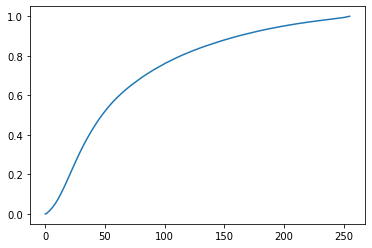

In [13]:
d_foret = densite(h_foret)
plt.plot(d_foret);

La densité augmente fortement autour de l'intensité 25, ce qui correspond au pic de l'histogramme. 

Pour égaliser l'histogramme d'une image, on remplace donc chaque intensité $i$ par $F(i)$, que l'on remet entre 0 et 255: 

In [14]:
def egaliser(im):
    d_im = densite(hist(im))
    im_eq = np.zeros_like(im)
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            im_eq[i,j] = np.round(d_im[im[i, j]] * 255)
    return im_eq

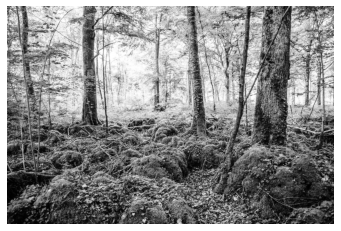

In [15]:
foret_eg = egaliser(foretg)
plt.axis('off')
plt.imshow(foret_eg, cmap = "gray");

Magnifique! Le contraste a été nettement amélioré. On peut remarquer qu'il y a des parties peut-être trop lumineuses: on peut introduire une limite pour éviter de trop augmenter la luminosité des pixels déjà lumineux.

Affichons le nouvel histogramme et comparons-le à l'ancien: 

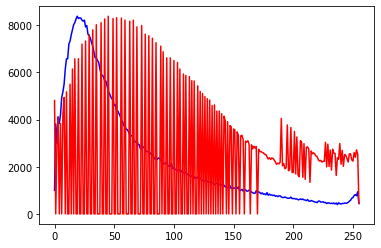

In [16]:
plt.plot(h_foret, color = "blue")
plt.plot(hist(foret_eg), color = "red");

Effectivement, le nouvel histogramme est bien mieux réparti. Le lecteur peut-il expliquer les discontinuités et les pics observés?  

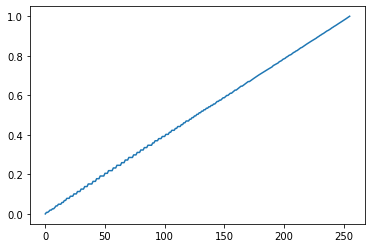

In [17]:
plt.plot(densite(hist(foret_eg)));

La nouvelle fonction de densité est linéaire, ce qui est exactement ce que l'on a voulu.

## Et en couleurs?

Essayons d'appliquer la méthode sur une image en couleurs:

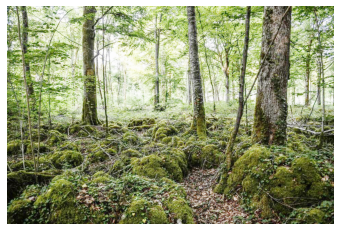

In [18]:
foret_eg_col = egaliser(foret)
plt.axis('off')
plt.imshow(foret_eg_col);

Cela fonctionne, alors que nous avons programmé nos fonctions pour des images en noir et blanc?!! <br> 
... <br>
C'est la magie des opérations et du broadcasting sur les tableaux numpy!